In [152]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [153]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=50, cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Classification

### Confusion Matrices

In [154]:
df = pd.read_csv('games.csv')
df

,GAME_ID,TEAM_NAME,FG_PCT,WON,TEAM_NAME_OPP,FG_PCT_OPP,FG_PCT_DIFF
0,21700001,Boston Celtics,0.41,0,Cleveland Cavaliers,0.46,-0.05
1,21700002,Golden State Warriors,0.54,0,Houston Rockets,0.48,0.05
2,21700003,Charlotte Hornets,0.40,0,Detroit Pistons,0.43,-0.03
...,...,...,...,...,...,...,...
1227,21701228,LA Clippers,0.49,0,Los Angeles Lakers,0.48,0.02
1228,21701229,Utah Jazz,0.37,0,Portland Trail Blazers,0.46,-0.09
1229,21701230,Houston Rockets,0.38,0,Sacramento Kings,0.47,-0.10


In [155]:
from sklearn.linear_model import LogisticRegression

X = df[['FG_PCT_DIFF']]
y = df['WON']

clf = LogisticRegression(penalty='none', solver='saga')
clf.fit(X, y)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [156]:
def plot_confusion(confusion):
    sns.heatmap(confusion, annot=True, fmt='d',
                cmap="Blues", annot_kws={'fontsize': 24}, square=True,
                xticklabels=[1, 0], yticklabels=[1, 0], cbar=False)
    plt.xlabel('True')
    plt.ylabel('Predicted')

In [157]:
y_pred = clf.predict(X)
confusion = np.array([
    [sum((y_pred == 1) & (y == 1)), sum((y_pred == 1) & (y == 0))],
    [sum((y_pred == 0) & (y == 1)), sum((y_pred == 0) & (y == 0))],
])
confusion

array([[472, 118],
       [133, 507]])

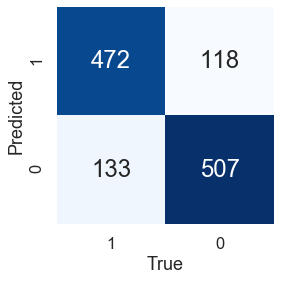

In [158]:
plot_confusion(confusion)

### ROC Curves

In [159]:
y_hat = clf.predict_proba(X)[:, 1]
y_hat

array([0.18, 0.83, 0.28, ..., 0.62, 0.06, 0.05])

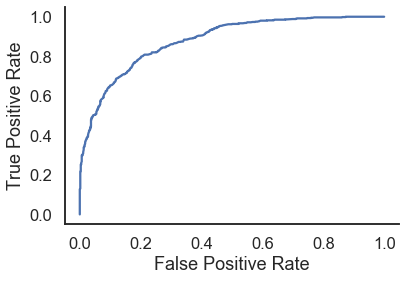

In [168]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, y_hat)
with sns.axes_style("white"):
    plt.plot(fpr, tpr)

sns.despine()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

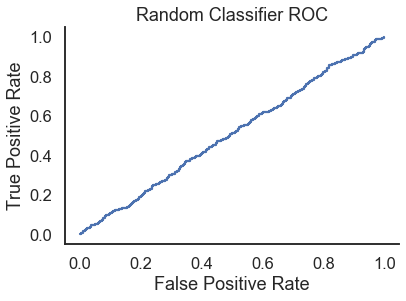

In [169]:
random_probs = np.random.uniform(size=len(y))

fpr, tpr, thresholds = roc_curve(y, random_probs)
with sns.axes_style("white"):
    plt.plot(fpr, tpr)

sns.despine()
plt.title('Random Classifier ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [170]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, y_hat)

0.880236694214876

You try: Draw the ROC curve for this small dataset of 5 points. Then compute the AUC.

In [172]:
np.random.seed(5)
X_small = X.sample(5)
y_small = y[X_small.index]
y_hat_small = clf.predict_proba(X_small)[:, 1]

In [173]:
@interact(thres=(0, 1, 0.1))
def adjust_thres(thres=1):
    pred = (y_hat_small >= thres).astype(int)
    df = (pd.DataFrame({'y': y_small, 'y_hat': y_hat_small, 'pred': pred})
          .sort_values('y_hat'))
    fpr = df.loc[df['y'] == 0, 'pred'].mean()
    tpr = df.loc[df['y'] == 1, 'pred'].mean()
    print(f'fpr: {fpr:.2f}       tpr: {tpr:.2f}')
    display_df(df)

interactive(children=(FloatSlider(value=1.0, description='thres', max=1.0), Output()), _dom_classes=('widget-i…

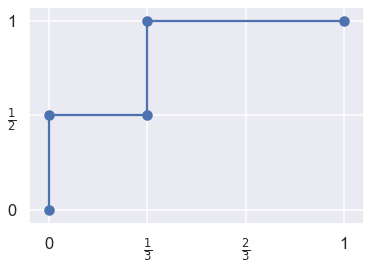

In [174]:
fpr, tpr, thresholds = roc_curve(y_small, y_hat_small)
plt.plot(fpr, tpr)
plt.scatter(fpr, tpr)
plt.xticks([0, 1/3, 2/3, 1], ['0', r'$\frac{1}{3}$', r'$\frac{2}{3}$', r'1'])
plt.yticks([0, 0.5, 1], ['0', r'$\frac{1}{2}$', r'1']);

### Logistic regression summary

The logistic or sigmoid function can be written two equivalent ways:

$$\sigma(t) = \frac{1}{1 + \exp(-t)} = \frac{\exp(t)}{1 + \exp(t)} $$

The logistic regression model assumes the following probabilities of $Y \in \{0, 1\}$ given column vector $X$:

\begin{align*}
P(Y=1|X) &= \sigma(X^T \theta) &&= \frac{1}{1 + \exp(-X^T \theta)} &= \frac{\exp(X^T\theta)}{1 + \exp(X^T\theta)} \\[10pt]
P(Y=0|X) &= \sigma(-X^T \theta) &&= \frac{1}{1 + \exp(X^T \theta)}  \\
\end{align*}

The loss most typically used to fit $\theta$ is the log loss or cross-entropy loss, which is the negative log probability of the correct (observed) $Y$ value. This loss for true $Y \in \{0, 1\}$ and predicted probability $\hat Y \in [0, 1]$ is often written:

$$-Y \log(\hat Y) - (1-Y)\log(1- \hat Y)$$

In [175]:
def sigmoid(t):
    """The logistic or sigmoid function, denoted σ(t).
    
    Note: This is actually a special case of what is generally 
          named the "logistic" function,
          which allows for a different numerator and offset, 
          but lots of people call this the logistic function in practice.
    """
    return 1 / (1 + np.exp(-t))

def prediction(x, theta):
    """Prediction under the logistic model for features x and parameters b."""
    return sigmoid(x @ theta)

def squared_loss(y, y_hat):
    """Squared loss applies to any true y and predicted y_hat."""
    return (y - y_hat) ** 2

def log_loss(y, y_hat):
    """Log loss or cross-entropy loss, assuming y is in [0, 1]."""
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def empirical_risk(true_ys, predicted_ys, loss):
    """The empirical risk is the average loss for a sample."""
    return np.average(loss(true_ys, predicted_ys))

### Empirical Risk

Filling in $\hat Y = P(Y=1|X)$ and filling in the form of the model, we find different ways of expressing the same loss:

\begin{align*}
L(\theta) &= -Y \log(\hat Y) - (1-Y)\log(1- \hat Y) \\[10pt]
         &= - Y \log P(Y=1|X) - (1-Y) \log P(Y=0|X)  \\[10pt]
         &= - Y \log \frac{\exp(X \cdot \theta)}{1 + \exp(X \cdot \theta)} - (1-Y) \log \frac{1}{1 + \exp(X \cdot \theta)}  \\[10pt]
         &= - Y (\log(\exp(X \cdot \theta)) - \log(1 + \exp(X \cdot \theta))) - (1-Y) (-\log (1 + \exp(X \cdot \theta)))  \\[10pt]
         &= - YX \cdot \theta + Y \log(1 + \exp(X \cdot \theta))) - Y \log(1 + \exp(X \cdot \theta))) + \log (1 + \exp(X \cdot \theta))  \\[10pt]
         &= - YX \cdot \theta + \log (1 + \exp(X \cdot \theta)) \\[10pt]
         &= -\left(YX \cdot \theta + \log \sigma(-X \cdot \theta)\right)
\end{align*}

Where the last step follows from $\log (1 + \exp(X \cdot \theta)) = -(- \log (1 + \exp(X \cdot \theta))) = -\log \frac{1}{1 + \exp(X \cdot \theta)} = -\log \sigma(-X \cdot \theta)$.

The empirical risk (average loss across a sample) for a set of observations $(x_1, y_1) \dots (x_n, y_n)$ is often written:

$$R(\theta, x, y) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i x_i \cdot \theta + \log \sigma(-x_i \cdot \theta) \right]$$

### Logistic Regression Gradient

Using the logistic regression model and log loss, find the gradient of the empirical risk.

First, we compute the derivative of the sigmoid function since we'll use it in our gradient calculation.

$$
\begin{aligned}
\sigma(t) &= \frac{1}{1 + e^{-t}} \\[10pt]
\sigma'(t) &= \frac{e^{-t}}{(1 + e^{-t})^2} \\[10pt]
\sigma'(t) &= \frac{1}{1 + e^{-t}} \cdot \left(1 - \frac{1}{1 + e^{-t}} \right) \\[10pt]
\sigma'(t) &= \sigma(t) (1 - \sigma(t))
\end{aligned}
$$

As a shorthand, we define $ \sigma_i = \sigma(-x_i\cdot \theta) $. We will soon need the gradient of $ \sigma_i $ with respect to the vector $ \theta $ so we will derive it now using the chain rule. 

\begin{align*}
\nabla_{\theta} \sigma_i
&= \nabla_{\theta} \sigma(-x_i\cdot \theta) \\[10pt]
&= \sigma\left(-x_i\cdot \theta\right) \left(1 - \sigma(-x_i\cdot \theta)\right)  \nabla_{\theta} \left(-x_i\cdot \theta\right) \\[10pt]
&= -\sigma_i (1 - \sigma_i) x_i 
\end{align*}

Now, we derive the gradient of the cross-entropy loss with respect to the model parameters $ \boldsymbol{\theta} $. We use the fact that $(1-\sigma_i) = \sigma(x_i \cdot \theta)$, since $\sigma(x \cdot \theta) + \sigma(-x \cdot \theta) = 1$.

\begin{align*}
R(\theta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i \cdot \theta + \log \sigma_i \right] \\[10pt]
\nabla_{\theta} R(\theta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \frac{1}{\sigma_i} \sigma_i (1 - \sigma_i) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \sigma(x_i \cdot \theta) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i \cdot \theta)\right) x_i  \\[10pt]
\end{align*}

The gradient for a single point is the expression inside the summation. This lets us run SGD.

In [219]:
def gradient_descent(x, y, theta0, gradient_function, max_iter=1000000,  
                     epsilon=1e-8, lr=5, clip=1):
    """Run gradient descent on a dataset (x, y) 
    with gradient clipping and learning rate decay."""
    theta = theta0
    for t in range(1, max_iter):
        grad = gradient_function(theta, x, y)
        theta -= (lr/(1 + t/1000)) * np.clip(grad, -clip, clip)
        # Print progress
        if t % 50000 == 0:
            risk = empirical_risk(y, prediction(x, theta), log_loss)
            print(f'Iter {t}: {theta} {grad} {risk:.6f}')
        # Detect approximate convergence: small gradient
        if np.linalg.norm(grad) < epsilon:
            return theta
    return theta

def risk_gradient(theta, x, y):
    """Risk gradient for a whole dataset at once."""
    n = x.shape[0]
    return -(1/n) * x.T @ (y - sigmoid(x @ theta)) 

def logistic_regression(x, y):
    """Train a logistic regression classifier using gradient descent."""
    theta0 = np.zeros(x.shape[1])
    theta = gradient_descent(x, y, theta0, risk_gradient)
    return theta

### Applying logistic regression

In [250]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
0,17.99,10.38,122.80,1001.0,...,0.46,0.12,1.0,1
1,20.57,17.77,132.90,1326.0,...,0.28,0.09,1.0,1
2,19.69,21.25,130.00,1203.0,...,0.36,0.09,1.0,1
...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,...,0.22,0.08,1.0,1
567,20.60,29.33,140.10,1265.0,...,0.41,0.12,1.0,1
568,7.76,24.54,47.92,181.0,...,0.29,0.07,1.0,0


In [251]:
display_df(cancer.describe())

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
count,569.00,569.00,569.00,569.00,...,569.00,569.00,569.0,569.00
mean,14.13,19.29,91.97,654.89,...,0.29,0.08,1.0,0.37
std,3.52,4.30,24.30,351.91,...,0.06,0.02,0.0,0.48
min,6.98,9.71,43.79,143.50,...,0.16,0.06,1.0,0.00
25%,11.70,16.17,75.17,420.30,...,0.25,0.07,1.0,0.00
50%,13.37,18.84,86.24,551.10,...,0.28,0.08,1.0,0.00
75%,15.78,21.80,104.10,782.70,...,0.32,0.09,1.0,1.00
max,28.11,39.28,188.50,2501.00,...,0.66,0.21,1.0,1.00


In [252]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


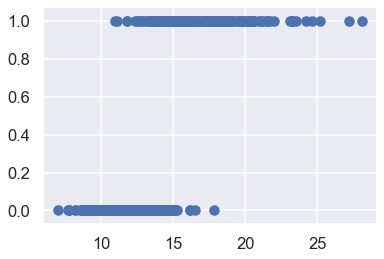

In [253]:
plt.scatter(train['mean radius'], train['malignant']);

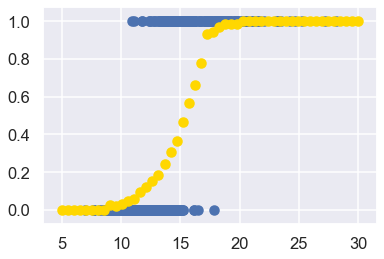

In [254]:
radii = np.linspace(5, 30, 50)
averages = [np.average(train[np.abs(train['mean radius']-r)<2]['malignant']) for r in radii]
plt.scatter(train['mean radius'], train['malignant']);
plt.scatter(radii, averages, color='gold');

In [255]:
def features(t):
    return t[['bias', 'mean radius']].values
    
x_train, y_train = features(train), train['malignant'].values

In [256]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
model.fit(x_train, y_train)
model.coef_

array([[-14.9 ,   1.01]])

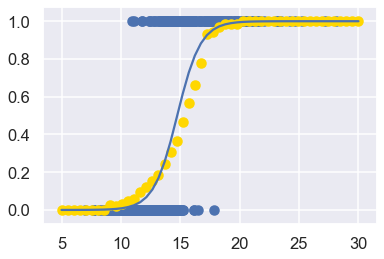

In [257]:
plt.scatter(train['mean radius'], train['malignant']);
plt.scatter(radii, averages, color='gold');
plt.plot(radii, sigmoid(model.coef_[0,0] + radii * model.coef_[0,1]));

In [258]:
%%time

theta = logistic_regression(x_train, y_train)
print(theta)

Iter 50000: [-0.2   0.02] [-0.15 -3.47] 0.680938
Iter 100000: [-13.96   0.94] [ 0. -0.] 0.300149
Iter 150000: [-14.79   1.  ] [ 0. -0.] 0.299669
Iter 200000: [-14.87   1.01] [ 0. -0.] 0.299663
Iter 250000: [-14.89   1.01] [ 0. -0.] 0.299663
Iter 300000: [-14.89   1.01] [ 0. -0.] 0.299662
Iter 350000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 400000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 450000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 500000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 550000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 600000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 650000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 700000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 750000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 800000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 850000: [-14.9    1.01] [ 0. -0.] 0.299662
Iter 900000: [-14.9    1.01] [ 0. -0.] 0.299662
[-14.9    1.01]
CPU times: user 31.3 s, sys: 355 ms, total: 31.7 s
Wall time: 33 s


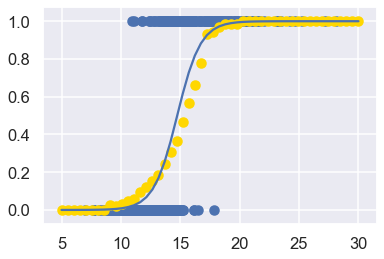

In [259]:
plt.scatter(train['mean radius'], train['malignant']);
plt.scatter(radii, averages, color='gold');
plt.plot(radii, sigmoid(theta[0] + radii * theta[1]));

In [262]:
sklearn_pred = sigmoid(x_train @ model.coef_[0])
empirical_risk(y_train, sklearn_pred, log_loss)

0.2996624823521378

In [263]:
our_pred = sigmoid(x_train @ theta)
empirical_risk(y_train, our_pred, log_loss)

0.2996624822677564

Checking test set performance:

In [264]:
x_test = features(test)
y_test = test['malignant'].values
print(f'{y_test.sum()}/{len(y_test)} malignant')

56/143 malignant


In [265]:
def auc(X, y, theta):
    y_pred = sigmoid(X @ theta)
    return roc_auc_score(y, y_pred)

In [266]:
auc(x_train, y_train, theta)

0.9314339981006647

In [267]:
auc(x_test, y_test, theta)

0.9517651888341543

Using all features:

In [268]:
def all_features(t):
    return t.drop('malignant', axis=1).values

model = LogisticRegression(fit_intercept=False, C=1e9, solver='saga',
                           max_iter=10000)
model.fit(all_features(train), y_train)
theta = model.coef_[0]
theta

array([-0.02,  0.01, -0.1 , ...,  0.  ,  0.  , -0.  ])

In [269]:
def evaluate(theta, features):
    print(f'Train auc: {auc(features(train), y_train, theta):.3f}')
    print(f' Test auc: {auc(features(test), y_test, theta):.3f}')
    
evaluate(theta, all_features)

Train auc: 0.968
 Test auc: 0.989


## Lecture Images

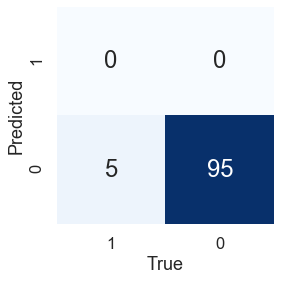

In [167]:
plot_confusion(np.array([
    [0, 0],
    [5, 95],
]))

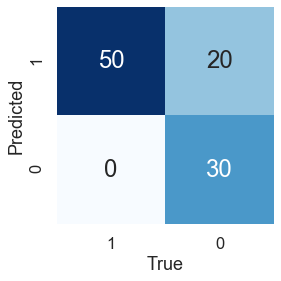

In [165]:
plot_confusion(np.array([
    [50, 20],
    [0, 30],
]))

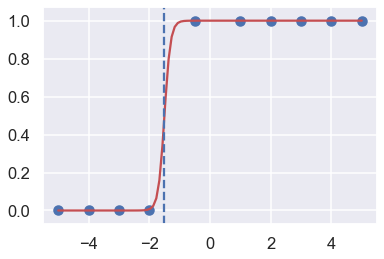

In [94]:
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -0.5, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1,   1, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y'])

xs = np.linspace(-5, 5, 100)
ys = sigmoid(10 * (xs + 1.5))
plt.plot(xs, ys, c='r')
plt.axvline(-1.5, linestyle='--')